In [1]:
# import necessary libraries and files

import os
import matplotlib.pyplot as plt

from project_functions import *
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk

In [2]:
# PATH DEF
path_to_ref = "./dataset/references"
path_to_train = "./dataset/train"
path_to_test = "./dataset/test"

path_to_labels = "./dataset/train.csv"
path_to_submission = "./dataset/sample_submission.csv"

assert os.path.exists(path_to_ref), "ERROR: references folder not found"
assert os.path.exists(path_to_train), "ERROR: train folder not found"
assert os.path.exists(path_to_test), "ERROR: test folder not found"
assert os.path.exists(path_to_labels), "ERROR: labels for training not found"
assert os.path.exists(path_to_submission), "ERROR: submission file not found"

# CHOCO TYPES
amandina = "1. Amandina"
arabia = "2. Arabia"
comtesse = "3. Comtesse"
creme_brulee = "4. Crème brûlée"
jelly_black = "5. Jelly black"
jelly_milk = "6. Jelly milk"
jelly_white = "7. Jelly white"
noblesse = "8. Noblesse"
noir_authentique = "9. Noir authentique"
passion_lait = "10. Passion au lait"
stracciatella = "11. Stracciatella"
tentation_noir = "12. Tentation noir"
triangolo = "13. Triangolo"

In [3]:
# LOADING DATA

ref_img = np.load("ref_images.npy")

# train_data = np.load("train_data.npz")
# train_img = train_data["images"]
# train_labels = train_data["labels"]

# train_img = np.load("test_images.npy")

In [4]:
ref_img.shape

(13, 4000, 6000, 3)

# What are we doing to obtain the masks/contours
The biggest problem is the big variety between all the chocolates. We could think that detecting/masking them could be done through edge detection, however due to multiple factors (image quality, shadows, reflections and chocolate colours) such a method does not give reliable results. 

For that reason our goal is to create, for the moment, a mask that should be capable of highlighting the rough shape of all chocolate types.

For the moment we are at the plain background which can cause a lot of noise into the image. To avoid this troubling us, we will try and remove it as much as possible. To do this we use :
    Gaussian blur to smooth over full image and remove this from the original which immediatly removes alotof homogeneity from the background. and leaves only elements that show more detail.

After this CLAHE is applied. To increase local contrast (help with edge detection with areas that are not very clear)

Multiple morphological transformations are then applied to enhanced desired elements and reduce any noise coming from the image or previous processes.

These are then thresholded to have a binary image on which further morphology processes are applied to have a mask that covers the area of the chocolate as best as possible.

Also saw this:
https://docs.opencv.org/3.4/d2/dbd/tutorial_distance_transform.html 



!!! Comtesse appears to not be a complete mask and bad contour. Am still testing more transforms to have good results for it.

In [8]:
square = np.ones((5, 5), dtype=np.uint8)

def filter_small_components(binary, min_area=175):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    large_components = [i for i in range(1, num_labels) if stats[i, cv2.CC_STAT_AREA] >= min_area]
    mask = np.isin(labels, large_components).astype(np.uint8) * 255
    return mask

def multi_dil(im, num, element=square):
    return cv2.dilate(im, element, iterations=num)

def multi_ero(im, num, element=square):
    return cv2.erode(im, element, iterations=num)

def morph_open_and_close_pipeline(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    bg = cv2.GaussianBlur(gray, (51, 51), 0)
    corrected = cv2.subtract(gray, bg)

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(16, 16))
    contrast = clahe.apply(corrected)

    # Reuse kernels
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_close1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (31, 31))
    kernel_close2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (37, 37))
    kernel_noise_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    kernel_close_final = cv2.getStructuringElement(cv2.MORPH_RECT, (151, 151))

    opened = cv2.morphologyEx(contrast, cv2.MORPH_OPEN, kernel_open)
    closed1 = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close1)
    closed2 = cv2.morphologyEx(closed1, cv2.MORPH_CLOSE, kernel_close2)
    cleaned = cv2.morphologyEx(closed2, cv2.MORPH_OPEN, kernel_noise_open)

    _, binary = cv2.threshold(cleaned, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_filtered = filter_small_components(binary, min_area=175)

    multi_dilated = multi_dil(binary_filtered, 10)
    closed = cv2.morphologyEx(multi_dilated, cv2.MORPH_CLOSE, kernel_close_final)
    closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel_close_final)

    # area_closed = area_closing(closed, area_threshold=80000)  # optional to replace
    multi_eroded = multi_ero(closed, 7)
    reconnected = cv2.dilate(multi_eroded, square, iterations=1)
    closed3 = cv2.morphologyEx(reconnected, cv2.MORPH_OPEN, square)

    return contrast, binary, closed3

def show_results(contrast, binary, filtered):
    plt.figure(figsize=(15, 4))
    titles = ["CLAHE Contrast", "Otsu Binary", "Final Filtered"]
    images = [contrast, binary, filtered]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Image 0


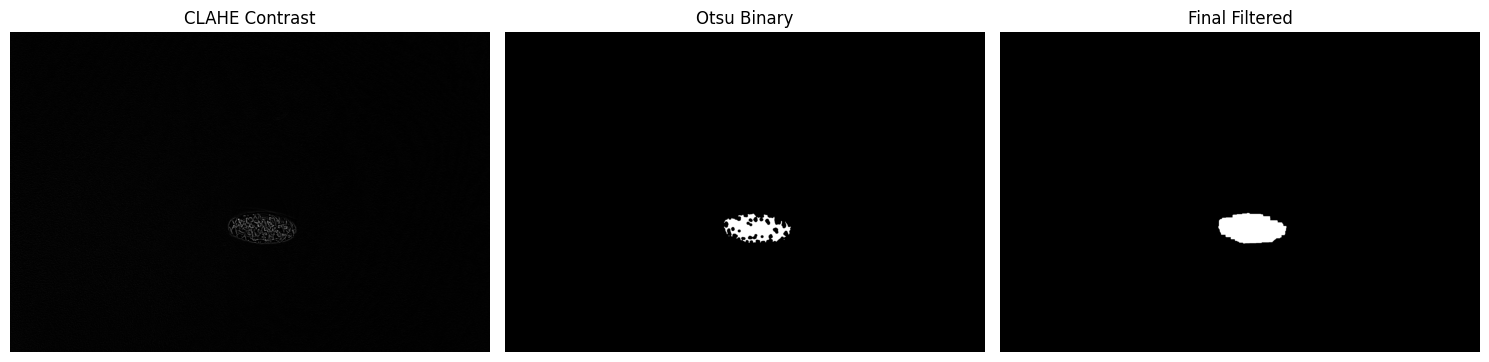

Image 1


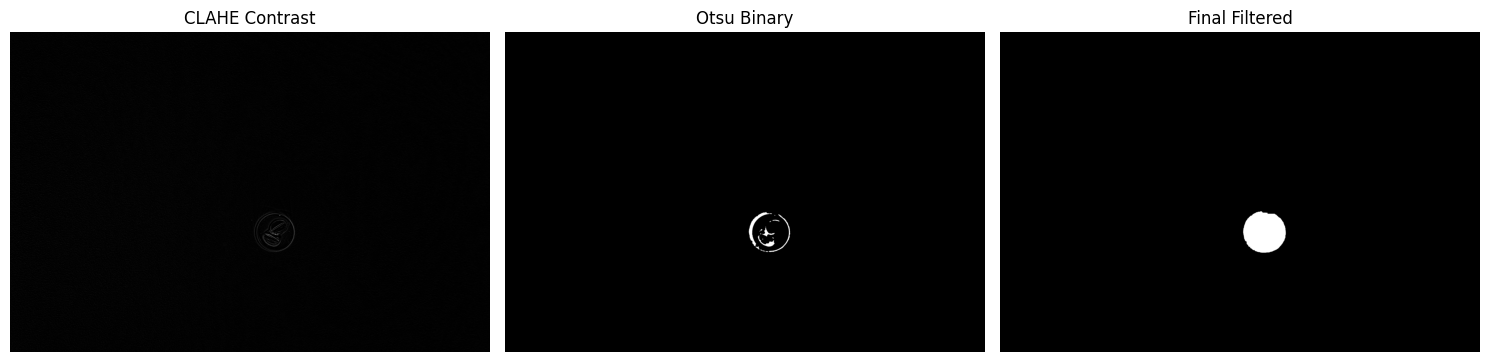

Image 2


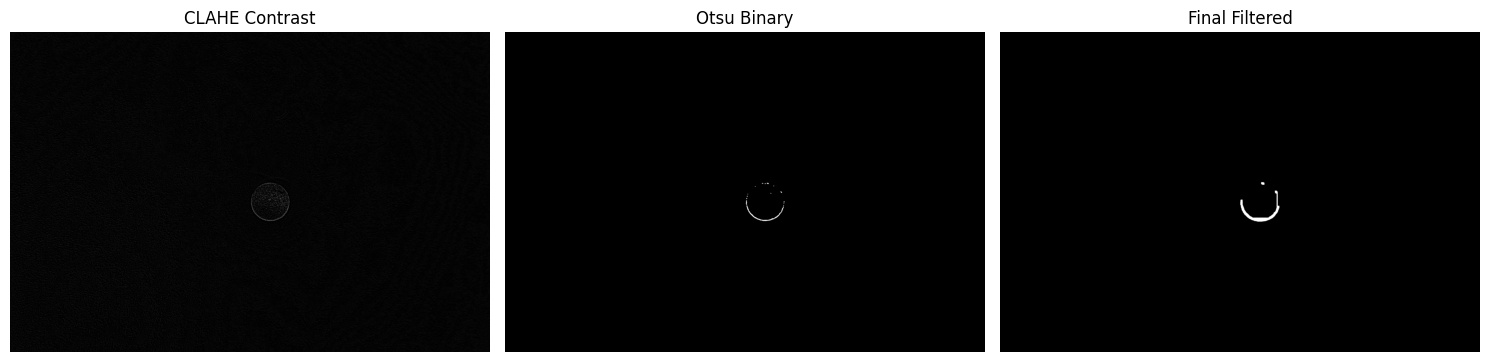

Image 3


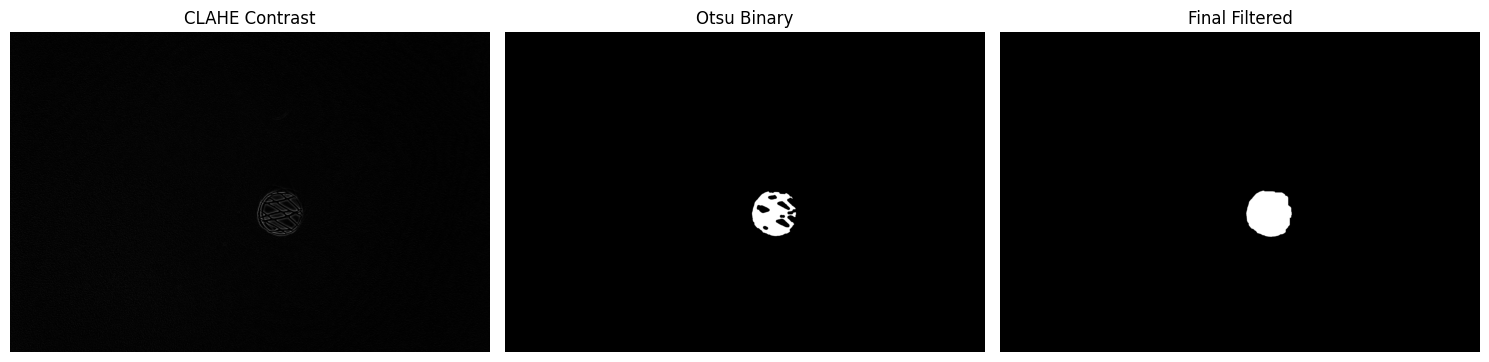

Image 4


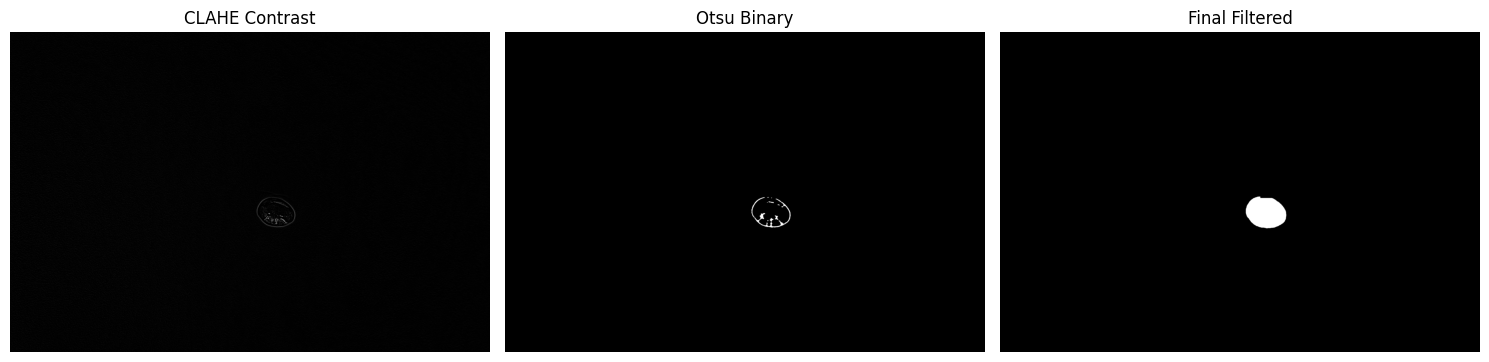

Image 5


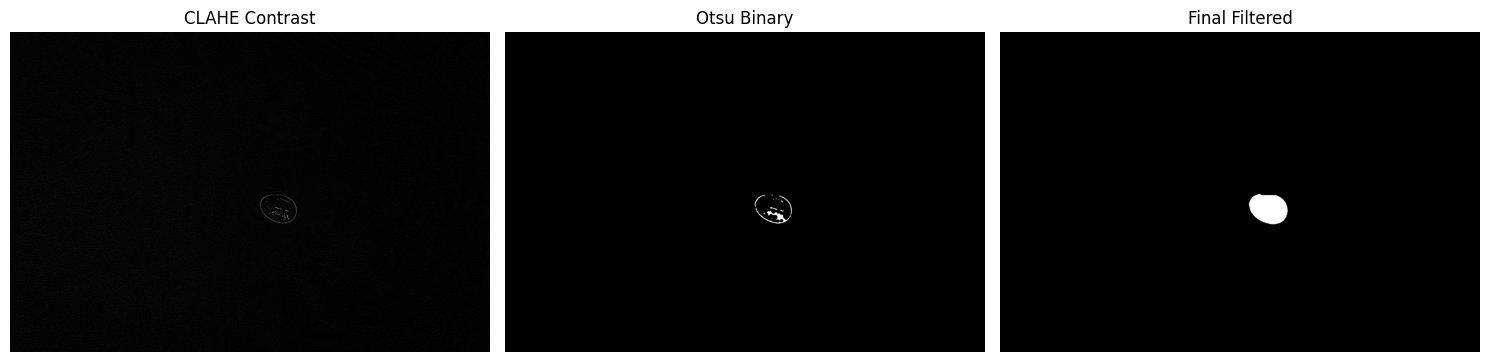

Image 6


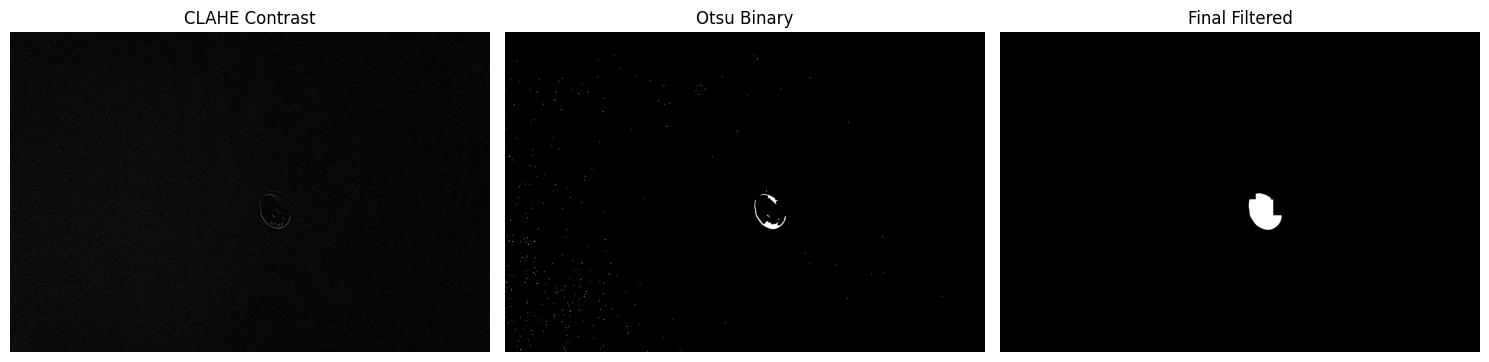

Image 7


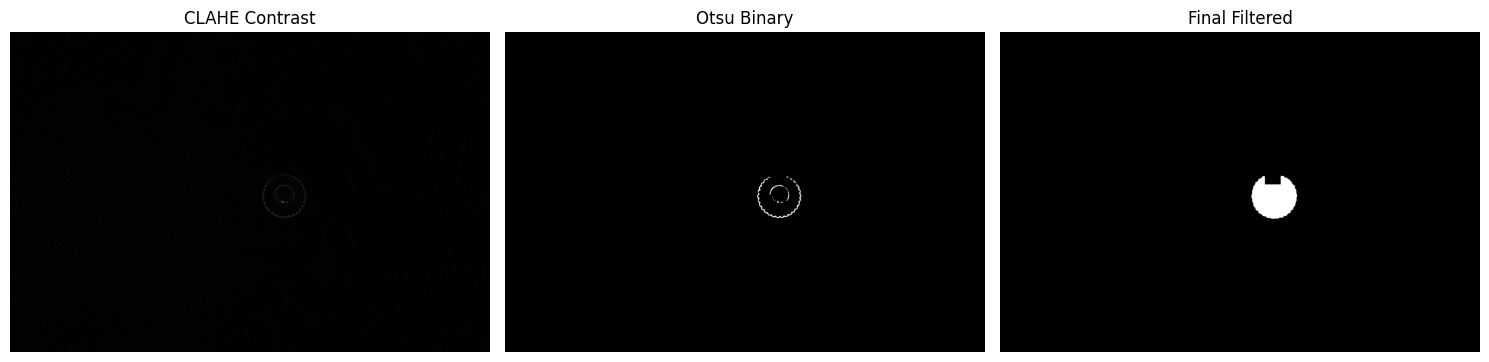

Image 8


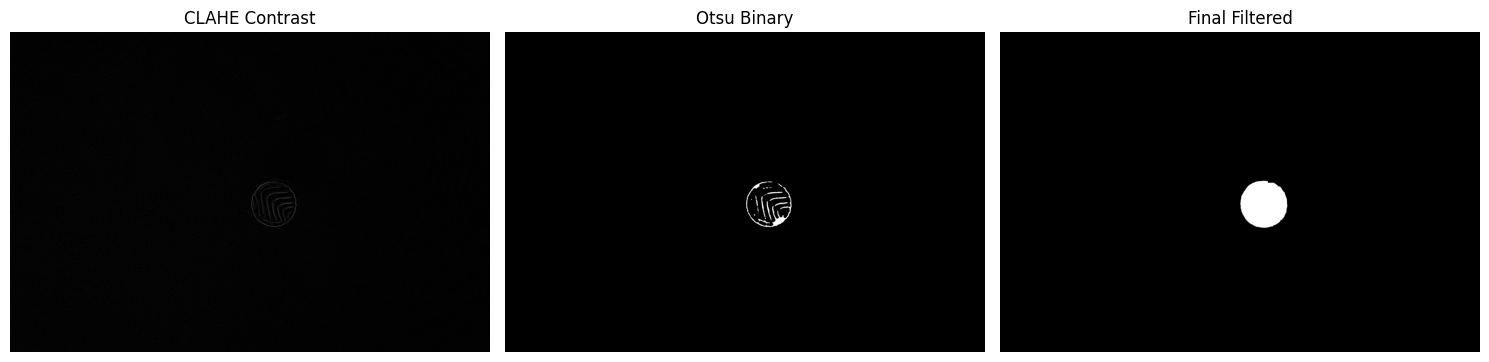

Image 9


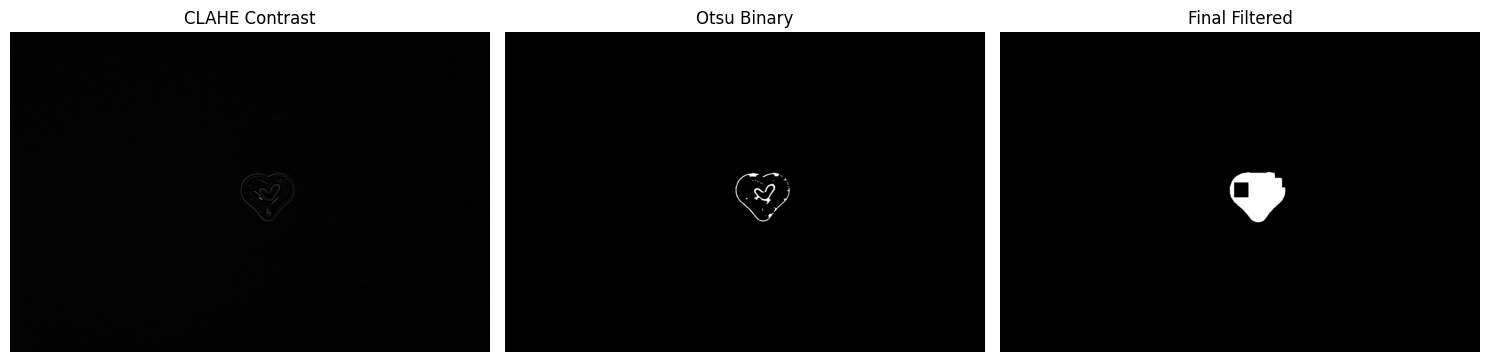

Image 10


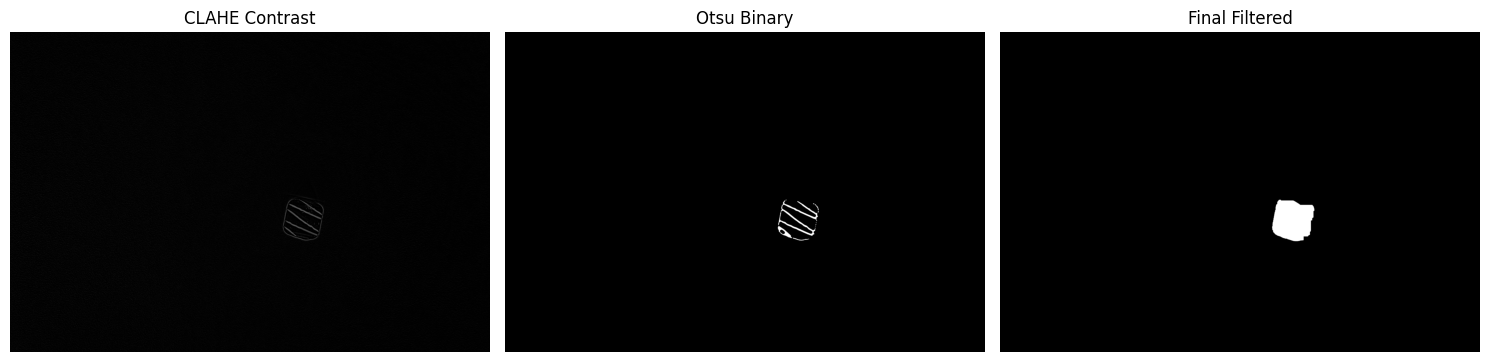

Image 11


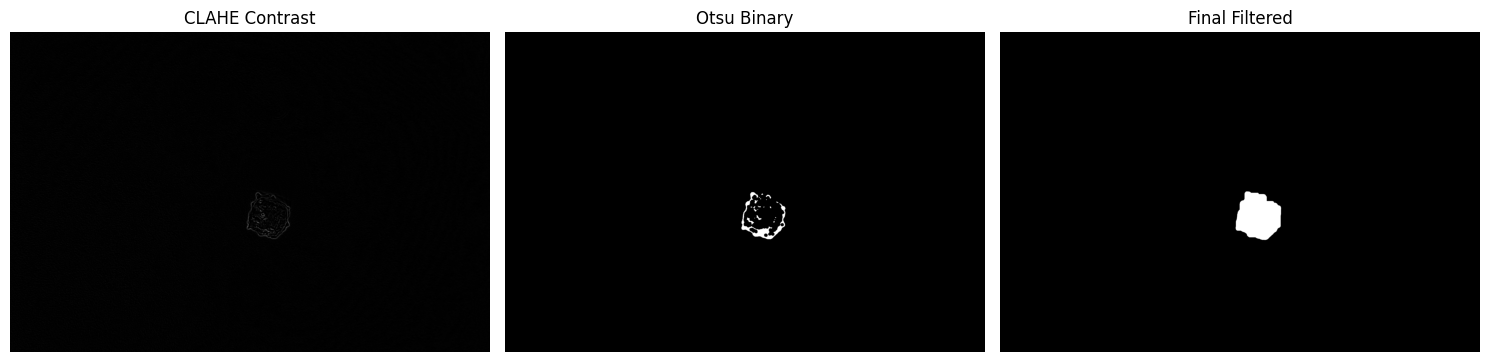

Image 12


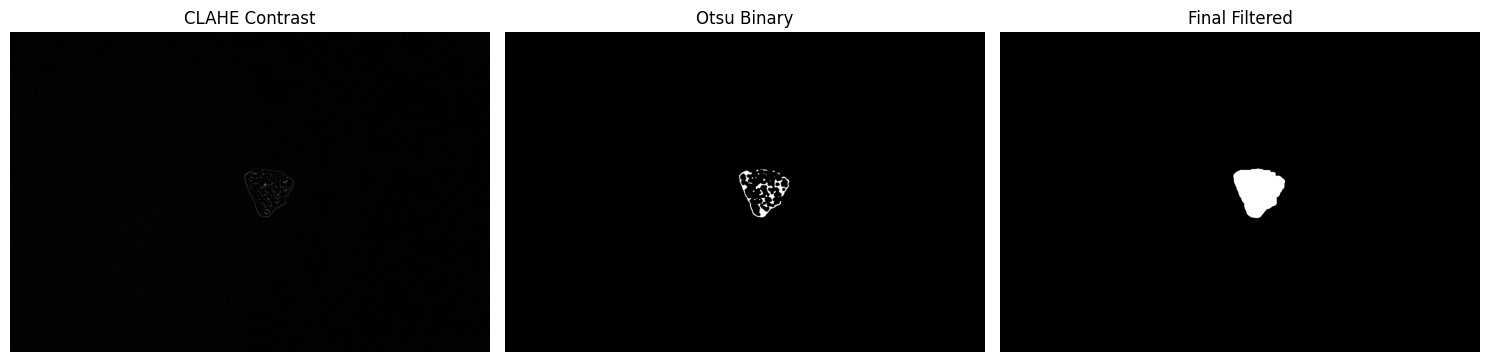

In [7]:
for idx, img_rgb in enumerate(ref_img):
    contrast, binary, filtered = morph_open_and_close_pipeline(img_rgb)
    print(f"Image {idx}")
    show_results(contrast, binary, filtered)